# Inits

In [2]:
%load_ext autoreload 

In [3]:

%autoreload 2

%matplotlib inline

import sys
sys.path.append('../')
import fluctuations
import logfft


import matplotlib.pyplot as plt

import numpy as np
import pickle
from scipy.interpolate import interp1d as int1d
from scipy.integrate import nquad
from scipy.special import spherical_jn as sjn
import time
from scipy import integrate 

from scipy.special import spherical_jn

import pyfftlog



Bad key text.latex.preview in file matplotlibrc, line 14 ('text.latex.preview : False')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.1/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
# Plot parameters

import matplotlib.pylab as pylab
from plot_params import params
pylab.rcParams.update(params)

cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
# Cosmological and 21-cm Parameters for xA_eff. Change if necessary. 
Omega_b_h = 0.0327
Omega_m   = 0.307


T_0 = 2725. # in mK

# Assuming baryon-to-photon ratio of 6e-10. 
nB = 2.46e-7 # per cm^-3, present day
Yp = 0.245
nH = (1. - Yp) * nB # per cm^-3, present day




In [100]:
fluc = fluctuations.Velocity_Fluctuations()


# Data from Yacine + interpolation

We are given the following decomposition of the two-point correlation function, 
$$
    c^{ij}(x) = \frac{\langle v^i v^j \rangle (x)}{\sigma^2_{1d}} = c_\parallel(x) \hat{x}^i \hat{x}^j + c_\perp(x) (\delta^{ij} - \hat{x}^i \hat{x}^j)
$$
where $\sigma_{1d} = 17$ km/s, which is $\sqrt{3}$ less than the oft-quoted $\sigma_{3d} = 29$ km/s. 

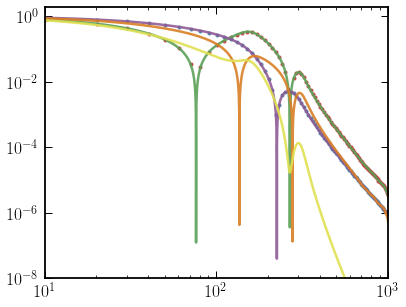

In [7]:
corrs=np.loadtxt(open('../correlations.dat'), delimiter="\t")

xlis=corrs[:,0]

x_ary = np.arange(0, 1000, .001)

cparint = int1d(xlis, corrs[:,1], kind=9)
cperpint = int1d(xlis, corrs[:,2], kind=9)

cpar_ary  = fluc.cparint(x_ary)
cperp_ary = fluc.cperpint(x_ary)

plt.xlim(10, 1e3)
plt.ylim(1e-8, 2)
plt.loglog(corrs[:,0],np.abs(corrs[:,1]),'.')
plt.loglog(corrs[:,0],np.abs(corrs[:,2]),'.')
plt.loglog(x_ary,np.abs(cpar_ary),'-')
plt.loglog(x_ary,np.abs(cperp_ary),'-')
plt.loglog(x_ary,np.abs((2*cperp_ary+cpar_ary)/3),'-')
plt.loglog(x_ary,(2*cperp_ary**2+cpar_ary**2)/3,'-')

# Generate $\Delta_v^2$ and $\Delta_{v^2}^2$

The relationship between the Fourier transformation of $\langle v^i v^j \rangle$ with $c_\parallel$ and $c_\perp$ is
$$
    c_\parallel(x) = \frac{1}{\sigma_{3d}^2} \int \frac{dk}{k} \Delta_{v_\text{rel}}^2(k) (j_0(kx) - 2 j_2(kx)) \qquad c_\perp(x) = \frac{1}{\sigma_{3d}^2} \int \frac{dk}{k} \Delta_{v_\text{rel}}^2(k) (j_0 (kx) + j_2(kx))
$$
$\Delta_{v_{bc}^2}$ is the dimensionless power spectrum, which is related to $\langle \mathcal{V}(\vec{k}) \mathcal{V}(\vec{k}')^* \rangle$ by 
$$
    \Delta_{v_\text{rel}}^2 = \frac{k^3}{2\pi^2} P_{v_{bc}}(k) = \frac{k^3}{2 \pi^2} (2\pi)^3 \delta_D(\vec{k}' - \vec{k}) P_{v_{bc}}(k)
$$


From the expressions above, we see that 
$$
\begin{alignat*}{1}
    c_\parallel(x) + 2 c_\perp(x) &= \frac{3}{\sigma_{3d}^2} \int \frac{dk}{k} \Delta_{v_{bc}}^2(k) j_0 (kx) \\ 
    &= \frac{1}{\sigma_{1d}^2} \int \frac{dk}{k} \frac{k^3}{2\pi^2} P_{v_{bc}}(k) \frac{\sin(kr)}{kr} \\
    &= \frac{1}{\sigma_{1d}^2} \int \frac{d^3 \vec{k}}{(2\pi)^3} e^{i\vec{k} \cdot \vec{x}} P_{v_{bc}}(k)
\end{alignat*}
$$
i.e. 
$$
\begin{alignat*}{1}
    P_{v_{bc}} &= \sigma_{1d}^2 \int d^3 \vec{x} e^{-i \vec{k} \cdot \vec{x}} [c_\parallel(x) + 2 c_\perp(x)] = \sigma_{1d}^2 \int d^3 \vec{x}  [c_\parallel(x) + 2 c_\perp(x)] j_0(kx) \\
    \Delta_{v_{bc}} &= \frac{k^3}{2 \pi^2} \sigma_{1d}^2 \int d^3 \vec{x}  [c_\parallel(x) + 2 c_\perp(x)] j_0(kx) \\
    &= \frac{2k^2}{\pi} \sigma_{1d}^2 \int dx [c_\parallel(x) + 2 c_\perp(x)] x \sin(kx)
\end{alignat*}
$$

We can also check that $\langle v^2(\vec{0}) v^2(\vec{x}) \rangle$ can be expanded through Wick expansion (see notes) to get
$$
    \langle v^2(\vec{0}) v^2(\vec{x}) \rangle - \sigma_{3d}^4 = \frac{2}{9} \sigma_{3d}^4 [c_\parallel^2 + 2 c_\perp^2]
$$
and we can define the Fourier transform of this quantity as $P_{v^2}$. 

In [8]:
k_ary = np.logspace(-3, 1, num=300)

Delta2_vrel  = fluc.get_Delta2v(k_ary) 

Delta2_vrel2 = fluc.get_Delta2v2(k_ary)



In [9]:
%autoreload 2

k_vrel_fft, Delta2_vrel_fft = fluc.get_Delta2v(use_logfft=True) 

k_vrel2_fft, Delta2_vrel2_fft = fluc.get_Delta2v2(use_logfft=True)



Text(0, 0.5, '$\\Delta^2$ [km$^4$ s$^{-4}$]')

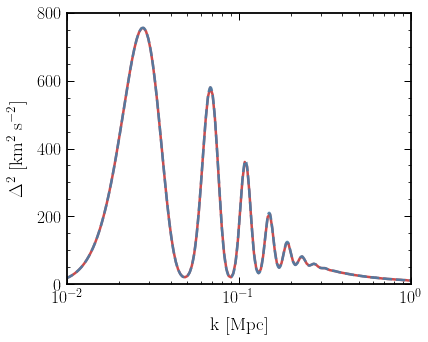

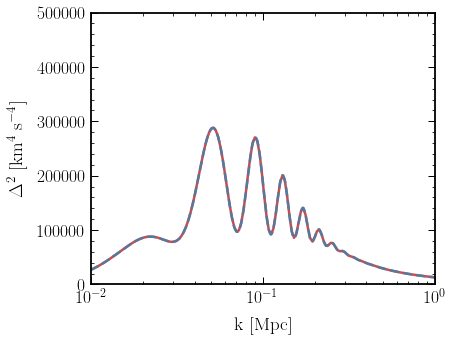

In [10]:
plt.figure()

plt.semilogx(k_ary, Delta2_vrel[1])
plt.semilogx(k_vrel_fft, Delta2_vrel_fft, '--')

plt.xlim(1e-2, 1)
plt.ylim(0, 800)

plt.xlabel(r'k [Mpc]')
plt.ylabel(r'$\Delta^2$ [km$^2$ s$^{-2}$]')

plt.figure()

plt.semilogx(k_ary,Delta2_vrel2[1])
plt.semilogx(k_vrel2_fft, Delta2_vrel2_fft, '--')

plt.xlim(1e-2, 1)
plt.ylim(0, 5e5)


plt.xlabel(r'k [Mpc]')
plt.ylabel(r'$\Delta^2$ [km$^4$ s$^{-4}$]')

We can check the normalization of these quantities. First, $P_{v_{bc}}$ is the Fourier transform of $\langle v^i(\vec{0}) v_i(\vec{x}) \rangle$ as well. And so
$$
    \int \frac{d^3 \vec{k}}{(2\pi)^3} P_{v_{bc}} = \int \frac{d^3 \vec{k}}{(2\pi)^3} \frac{2 \pi^2}{k^3} \Delta_{v_{bc}}^2 = \int \frac{dk}{k} \Delta_{v_{bc}}^2 = \langle v^2 \rangle = \sigma_{3d}^2
$$
Similarly, 
$$
    \int \frac{d^3 \vec{k}}{(2\pi)^3} P_{v^2} = \int \frac{dk}{k} \Delta_{v^2}^2 = \langle v^4 \rangle - \sigma_{3d}^4 = \frac{2}{3} \sigma_{3d}^4
$$

In [11]:
# Delta2_vrel is dimensionless: this integral should be sigma_3D^2 / sigma_1D^2 = 3
norm_Delta2_vrel = np.trapz(Delta2_vrel / k_ary, k_ary) 
print(norm_Delta2_vrel, 29**2)

norm_Delta2_vrel2 = np.trapz(Delta2_vrel2 / k_ary, k_ary) 
print(norm_Delta2_vrel2, (2/3) * 29**4)


[  9.999      839.98045347] 841
[9.99900000e+00 4.70349531e+05] 471520.6666666666


# Calculating $\Delta_T^2$ for a given dist

We are going to be integrating stuff over the gaussian PDF of velocities. In particular, 
$$
    f(\vec{v}) = \prod_{i = x,y,z}\frac{1}{\sqrt{2 \pi \sigma_{1d}^2}} e^{-v_i^2 / 2 \sigma_{1d}^2} = \frac{1}{(2 \pi \sigma_{1d}^2)^{3/2}} e^{- v^2/2 \sigma_{1d}^2} = \left( \frac{3}{2 \pi} \right)^{3/2} \frac{1}{\sigma_{3d}^3} e^{-3v^2 / 2\sigma_{3d}^2}
$$

With this, we can compute the mean and variance:
$$
    \langle g \rangle = \int dv \, 4\pi v^2 f(\vec{v}) g \quad \langle (g - \langle g \rangle)^2 \rangle = \langle g^2 \rangle - \langle g \rangle^2 = \int dv \, 4\pi v^2 f(\vec{v}) (g - \langle g \rangle)^2
$$

We also need
$$
    b[f] = \frac{3}{2} \left[ 1 - \frac{\langle v^2 f \rangle}{\langle f \rangle \sigma_{3d}^2} \right]
$$

In [12]:
# 3D MB velocity dist with vrms = 29 [km/sec]
# def MB(v):
#     return np.sqrt(27/(8*np.pi**3))/(29**3)*np.exp(-3*v**2/(2*29**2))

# # Mean of f(v)
# def Meanf(fv,v):
#     return 4*np.pi*np.trapz(MB(v)*v**2*fv,v)

# # Variance of f(v)
# def Varf(fv,v):
#     f_mean = Meanf(fv,v)
#     return 4*np.pi*np.trapz(MB(v)*v**2*(fv - f_mean)**2,v)
# #     return 4*np.pi*np.trapz(MB(v)*v**2*fv**2,v)-Meanf(fv,v)**2

# # This is now b^2 <f>^2
# def b2f(fv,v):
#     Vrms_sq = Meanf(v**2, v)
# #     return (9/4)*(4*np.pi*np.trapz(MB(v)*v**2*fv*(1 - v**2/Vrms_sq), v))**2
#     return (9/4)*(Meanf(fv,v)-4*np.pi*np.trapz(MB(v)*v**4*fv,v) / Vrms_sq)**2

In [81]:
# Calculation of x_A,eff. 

# Reading in Matlab data

import scipy.io
xA_param = scipy.io.loadmat('/users/hongwan/Dropbox (Princeton)/Fluctuations/for_Hongwan/xA_from_Anastasia/PT_LyACMB_NoRad.mat')
xA_data = scipy.io.loadmat('/users/hongwan/Dropbox (Princeton)/Fluctuations/for_Hongwan/xA_from_Anastasia/xA_LyACMB_NoRad.mat')

# These are the entries where X-ray heating is small. Pick any of these indices. 
print(np.argwhere(xA_param['PTout'][:,3] < 1e-3).flatten()[-7:])
ind = 3184

# print(xA_param['PTout'].shape)
print(xA_param['PTout'][ind, :])

xA_z_ary = np.arange(6., 51.)

xA_ary = xA_data['xAout'][ind] 

# In preparation for log-interpolation
xA_ary[xA_ary <= 0] = 1e-100

log10_xA_int = int1d(xA_z_ary, np.log10(xA_ary))


[3165 3170 3171 3175 3182 3184 3187]
[2.30000000e+01 5.81142300e-02 1.51778890e+01 6.38692123e-04
 1.30000000e+00 7.00000000e-01 5.98084785e+01 9.31983920e-02
 0.00000000e+00]


(10.0, 30.0, 1e-05, 10.0)

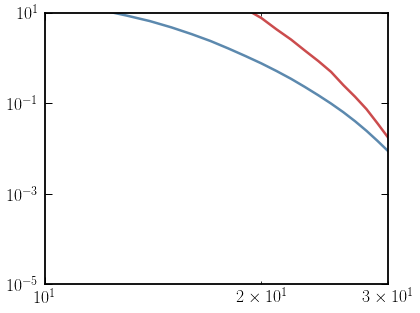

In [82]:
plt.figure()

plt.loglog()

for i in np.argwhere(xA_param['PTout'][:,3] < 1e-3).flatten()[-2:]:

    plt.plot(xA_z_ary, xA_data['xAout'][i,:])

plt.axis([10, 30, 1e-5, 10])

In [121]:
# Baryon temperature data. 

Vlis = np.loadtxt(open('/users/hongwan/Dropbox (Princeton)/Fluctuations/for_Hongwan/Tb_dat/Vlis.csv'), delimiter=",")
Qlis = np.loadtxt(open('/users/hongwan/Dropbox (Princeton)/Fluctuations/for_Hongwan/Tb_dat/Qlis.csv'), delimiter=",")
Tbarr= np.loadtxt(open('/users/hongwan/Dropbox (Princeton)/Fluctuations/for_Hongwan/Tb_dat/Tb17_mc100MeV_mm100MeV.csv'), delimiter=",")


# Tblis = Tbarr[70,:]

Tblis=Tbarr[70,:] * 1e3 # in mK


In [95]:
# Calculation of xA_eff (see 1605.04357 Eq. 57)

T_se = 402. # in mK
T_star = 68.2 # in mK, equivalent temperature of hyperfine splitting
A10 = 2.85e-15 # in s^-1, spontaneous decay rate of hyperfine transition

xA_z_17 = 10**log10_xA_int(17.)
print(xA_z_17)
xA_eff = xA_z_17 / (1 + T_se / Tblis) * np.exp(
    -2.06 * (Omega_b_h / 0.0327)**(1/3) * (Omega_m / 0.307)**(-1/6) * np.sqrt(18. / 10) * (Tblis / T_se)**(-2/3)
)
print(xA_eff)

# Calculation of xc (see 1605.04357 Eq. 46, taken from Zygelman: https://iopscience.iop.org/article/10.1086/427682/pdf)

# in mK
T_kappa_10_ary = np.array([1., 2., 4., 6., 8., 10., 15., 20., 25., 30., 40., 50., 60., 70., 80., 90., 100., 200., 300.]) * 1e3

# in cm^3 / sec
kappa_10_ary = np.array([1.38e-13, 1.43e-13, 2.71e-13, 6.60e-13, 1.47e-12, 2.88e-12, 9.10e-12, 1.78e-11, 2.73e-11, 3.67e-11, 5.38e-11, 6.86e-11, 8.14e-11, 9.25e-11, 1.02e-10, 1.11e-10, 1.19e-10, 1.75e-10, 2.09e-10])

log10_kappa_10_int = int1d(T_kappa_10_ary, np.log10(kappa_10_ary), bounds_error=False, fill_value=(np.log10(1.38e-13), np.log10(2.09e-10)))

# Tblis is in 
xc = 4 * 10**log10_kappa_10_int(Tblis) * nH * (18. ** 3) * T_star / 3. / A10 / (T_0 * 18.)

x_tot_eff = xc + xA_eff 


28.70078112710112
[1.86429573e-02 2.11939507e-02 2.35706284e-02 2.59930660e-02
 2.86908004e-02 3.18443302e-02 3.56595780e-02 4.02761516e-02
 4.57744351e-02 5.22353358e-02 5.97387624e-02 6.83616192e-02
 7.83623702e-02 9.04018677e-02 1.05305724e-01 1.23322886e-01
 1.44039551e-01 1.66960015e-01 1.92379416e-01 2.20964839e-01
 2.53181104e-01 2.88875982e-01 3.28152694e-01 3.78296641e-01
 4.54520514e-01 5.81260868e-01 8.16344246e-01 1.24658283e+00
 1.94674314e+00 2.91393914e+00 4.08838859e+00 5.36174793e+00
 6.62262513e+00 7.80214278e+00 8.88579616e+00 9.87706220e+00
 1.07795878e+01 1.15939406e+01 1.23232519e+01 1.29755647e+01
 1.35610135e+01 1.40884022e+01 1.45666047e+01 1.50033274e+01
 1.54014247e+01 1.57562553e+01 1.60644564e+01 1.63382985e+01
 1.66011212e+01 1.68688835e+01 1.71334627e+01 1.73804481e+01
 1.76024974e+01 1.78034990e+01 1.79880805e+01 1.81588342e+01
 1.83166701e+01 1.84625378e+01 1.85987160e+01 1.87278092e+01
 1.88515098e+01 1.89697425e+01 1.90821875e+01 1.91883028e+01
 1.928

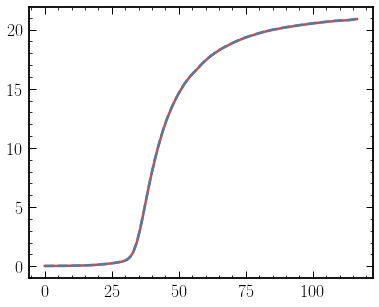

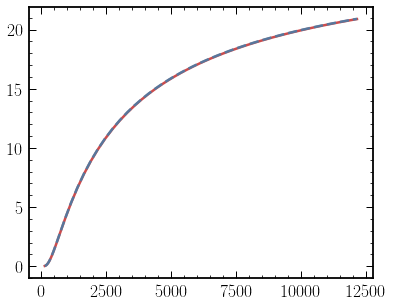

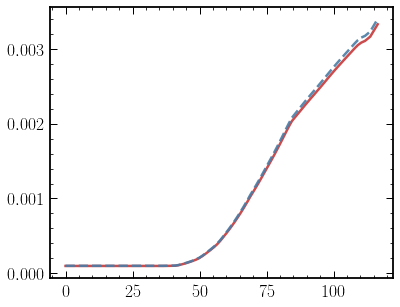

In [96]:
plt.figure()

plt.plot(Vlis, xA_eff)
plt.plot(Vlis, twenty_one.xA_eff(17, xA_z_17, Tblis*1e-3), '--')

plt.figure()

plt.plot(Tblis, xA_eff)
plt.plot(Tblis, twenty_one.xA_eff(17, xA_z_17, Tblis*1e-3), '--')

plt.figure()

plt.plot(Vlis, xc)
plt.plot(Vlis, twenty_one.xc(17, Tblis*1e-3), '--')

In [120]:
%autoreload

#Old T21
T21lis = 36*(1-49.095/Tblis)

#With the approximation that tau is small, should be (T_s - T_R)/(1+z)*tau in mK (see 1605.04357 Eq. 40 for the prefactor)
#We also introduce the x_tot,eff / (1 + x_tot,eff) factor to go between 1 - TCMB/TS and 1 - TCMB/TK (1605.04357 Eq. 56)
T21lis_small_tau = 26.8 * (Omega_b_h / 0.0327) * (Omega_m / 0.307)**(-0.5) * np.sqrt(18. / 10.) *  (1-T_0 * 18./Tblis)

# The actual value of tau, from the expression above. T21lis_small_tau is in mK. 
tau = T21lis_small_tau * 18. / (Tblis - T_0 * 18.)

# Actual T21 is (T_s - T_R)/(1+z) * (1 - exp(-tau)). Given in mK. 
T21lis = (Tblis - T_0 * 18.) / 18. * (1. - np.exp(-tau))

T21int=int1d(Vlis,T21lis,kind=2)

meanT, varT = fluc.mean_f(T21int, Vlis), fluc.var_f(T21int, Vlis) 
b2T = fluc.bias_f(T21int,Vlis)**2 * meanT**2 


dT2=fluc.var_f(int1d(Vlis[:-1], (np.diff(T21lis)/np.diff(Vlis))**2), Vlis[:-1])*29**2

print(meanT, varT, b2T, dT2)


-2118.365460823764 559021.0548200036 735905.3385522609 132710263764.56026


In [190]:
%autoreload 
T21_fluc = fluctuations.Fluctuations(17, Vlis, T21lis)

meanT, varT, b2T, dT2 = T21_fluc.mean, T21_fluc.var, T21_fluc.b**2 * T21_fluc.mean**2, T21_fluc.dT2 * 29**2

In [191]:
%autoreload 2
import twenty_one

test = twenty_one.get_T21(17, xA_z_17, Tblis*1e-3, TS_equal_Tb=True) * 1e3



print(np.transpose((test, T21lis)))


[[-2724.99287557 -2700.40096404]
 [-2724.99267705 -2697.64173343]
 [-2724.99250573 -2695.09193004]
 [-2724.9923423  -2692.51346853]
 [-2724.99217149 -2689.66582026]
 [-2724.9919844  -2686.36817232]
 [-2724.99177316 -2682.42211862]
 [-2724.99153578 -2677.70871499]
 [-2724.99127423 -2672.17898798]
 [-2724.99099055 -2665.79151231]
 [-2724.99068672 -2658.5139522 ]
 [-2724.99036466 -2650.3246178 ]
 [-2724.99001997 -2641.0423851 ]
 [-2724.98963749 -2630.15019821]
 [-2724.98920249 -2617.05513245]
 [-2724.9887206  -2601.74070312]
 [-2724.98821225 -2584.75392295]
 [-2724.9876938  -2566.64804836]
 [-2724.98716088 -2547.31689481]
 [-2724.9866031  -2526.41098959]
 [-2724.9860161  -2503.7843917 ]
 [-2724.98540668 -2479.73642048]
 [-2724.98477585 -2454.37130371]
 [-2724.98401864 -2423.45270438]
 [-2724.98294725 -2379.15320252]
 [-2724.9813181  -2311.39079845]
 [-2724.97861385 -2200.37184187]
 [-2724.97423154 -2030.50554574]
 [-2724.96777164 -1810.35550204]
 [-2724.95923713 -1573.17110663]
 [-2724.94

In [192]:
# print(T21lis)
print(meanT)
print(varT)
print(b2T)

-2118.365460823764
559021.0548200036
735905.3385522609


### Approximated correlations
#### Using our dimensionless notation we have 
$\xi_T(x)\simeq b_T^2\xi_{v_{\text {rel }}^{2}}(x)/9$ for lare x, and
$\operatorname{Var}[f]+\frac{1}{4}\left[\frac{\xi_{v_{\text {rel }}^{2}}(x)}{9}-\frac{2}{3}\right] \left\langle \left(V_{\mathrm{rms}}f^{\prime}\right)^{2}\right\rangle$ for small x

In [193]:
xiTlarge=xiv2_ary/9
xiTsmall=varT/b2T+(dT2/(4*b2T))*(xiv2_ary/9-2/3)
xiTtot=np.maximum(xiTlarge,xiTsmall)

# plt.xlim(0,30)
# plt.ylim(0.1,3)
plt.semilogy(x_ary,xiTlarge)
plt.semilogy(x_ary,xiTsmall)

plt.axis([0, 1, 0.1, 10])

NameError: name 'xiv2_ary' is not defined

### PS calculation (probably bad!)

In [194]:
# DelT2app=[];
# for i in range(300):
#     DelT2app.append(9*2*np.pi**(-1)*10**(2*klis[i])*np.trapz(xiTtot*xnew*np.sin(10**klis[i]*xnew),xnew))
    
# plt.semilogx(10**klis,b)
# plt.semilogx(10**klis,DelT2app)

# Full numerical calc

In [195]:
sig1=29/np.sqrt(3)
ulis=Vlis/sig1
ulis=np.linspace(ulis[0],ulis[-1],70)
zlis=np.linspace(-1,1, 50)

In [196]:
# def R(z,x):
    
#     return np.sqrt(cperpint(x)**2+(cparint(x)**2-cperpint(x)**2)*z**2)

# def R_vec(z,x):
    
#     term_1 = cperpint(x)**2 
#     term_2 = np.outer(z**2, cparint(x)**2 - cperpint(x)**2)
#     return np.sqrt(term_1 + term_2)

# def dW(u1,u2,z,x):
    
#     return (
#         (u1*u2/np.pi)*(R(z,x)*np.sqrt(1-R(z,x)**2))**(-1)
#         * 0.5 * np.exp(-(u1**2 - 2*R(z,x)*u1*u2 + u2**2)/(2*(1 - R(z,x)**2))) 
#         * (1. - np.exp(-2*R(z,x)*u1*u2/(1 - R(z,x)**2)))
#     )

# def dW_vec(u1,u2,z,x):
    
#     one_minus_R_sq   = 1. - R_vec(z,x)**2
    
#     u1_sq_plus_u2_sq = np.outer(u1**2, np.ones_like(u2)) + np.outer(np.ones_like(u1), u2**2)
    
#     term_1  = np.einsum('i,j,kl->ijkl',u1,u2,1./(R_vec(z,x)*np.sqrt(one_minus_R_sq))) / np.pi
#     term_2a_exp = np.einsum('ij,kl->ijkl', -u1_sq_plus_u2_sq, 1./(2*one_minus_R_sq))
#     term_2b_exp = np.einsum('i,j,kl->ijkl', u1, u2, 2*R_vec(z,x)/(2*one_minus_R_sq))
#     term_2 = 0.5*np.exp(term_2a_exp + term_2b_exp)
#     term_3 = 1. - np.exp(-2*term_2b_exp)
    
#     dW_zero_R = np.einsum(
#         'ij,i,j,kl->ijkl',
#         np.exp(-u1_sq_plus_u2_sq/2) / np.pi, u1**2, u2**2, np.ones_like(one_minus_R_sq)
#     )
    
# #     print(term_1)
# #     print(term_2)
# #     print(term_3)
# #     print('before subtraction: ', term_1*term_2*term_3)
# #     print('term to subtract: ', dW_zero_R)
    
#     large_R_term = term_1*term_2*term_3 - dW_zero_R
    
# #     print(large_R_term[9, 9, :, :])
# #     print('large R: ', large_R_term)
    
#     small_R_term = np.einsum(
#         'ij,i,j,kl->ijkl',
#         np.exp(-u1_sq_plus_u2_sq/2) / 6./ np.pi, u1**2 * (u1**2 - 3.), u2**2 * (u2**2 - 3), R_vec(z,x)**2
#     )
    
# #     print('small R: ', small_R_term)
    
#     mask = np.zeros_like(large_R_term)
#     mask[...,:,:] = R_vec(z,x)
    
#     large_R_mask = np.ones_like(mask)
#     small_R_mask = np.ones_like(mask)
    
#     large_R_mask[mask < 0.1] *= 0
#     small_R_mask[mask >= 0.1] *= 0
    
# #     print('R_vec: ', R_vec(z,x))
# #     print('large_R_mask: ', large_R_mask)
# #     print('small_R_mask: ', small_R_mask)
    
#     final_res = large_R_term*large_R_mask + small_R_term*small_R_mask
    
# #     print(final_res)
    
#     return final_res
    
# def dff(u1,u2,z,x):
    
#     return dW(u1,u2,z,x)*T21int(u1*sig1)*T21int(u2*sig1)

# def dff_vec(u1,u2,z,x):
    
#     return np.einsum('ijkl,i,j->ijkl',dW_vec(u1,u2,z,x), T21int(u1*sig1), T21int(u2*sig1))




In [197]:
%autoreload 2

x_small_ary = np.arange(0, 30, 0.1)

xiv2_small_ary = 2*(fluc.cparint(x_small_ary)**2 + 2 * fluc.cperpint(x_small_ary)**2)

xiT_small_ary = varT + dT2 / 4 * (xiv2_small_ary/9-2/3)

xiT_small_int = int1d(x_small_ary, xiT_small_ary, kind=9)

x_computed_ary = np.logspace(-1, 2., num=200)

# xiT_computed_ary = np.trapz(
#     np.trapz(
#         np.trapz(
#             dff_vec(ulis, ulis, zlis, x_computed_ary), zlis, axis=-2
#         ),
#         ulis, axis=-2
#     ),
#     ulis, axis=-2
# )

xiT_computed_ary = T21_fluc.xi_f_numerical(x_computed_ary)

xiT_computed_int = int1d(x_computed_ary, xiT_computed_ary, kind=9)

# x_large_ary = np.logspace(1, 3, num=1000)
x_large_ary = np.concatenate((
    np.logspace(1, 2, num=100)[:-1],
    np.logspace(2, np.log10(350), num=10000),
    np.logspace(np.log10(350), 3, num=100)[1:]
))

xiT_large_ary = 2 * (fluc.cparint(x_large_ary)**2 + 2*fluc.cperpint(x_large_ary)**2) * b2T / 9

xiT_large_int = int1d(x_large_ary, xiT_large_ary, kind=9)

def xiT(x, x_switch=90): 

    xiT_small    = xiT_small_int(x[x < 1])
    xiT_computed = xiT_computed_int(x[(x >= 1) & (x < x_switch)])
    xiT_large    = xiT_large_int(x[(x >= x_switch) & (x <= 1e3)]) 
    xiT_exceed   = np.zeros_like(x[x > 1e3])

    return np.concatenate((xiT_small, xiT_computed, xiT_large, xiT_exceed))

# x_full_ary = np.arange(0, 1000, 0.0005)
x_full_ary = np.concatenate((
    np.logspace(-5, np.log10(1e2), num=50000)[:-1], 
    np.logspace(np.log10(1e2), np.log10(4e2), num=200000),
    np.logspace(np.log10(4e2), 5, num=50000)[1:]
))

xiT_new_ary = xiT(x_full_ary)

# # Use the FFT to compute 
# DelTTn = -np.imag(np.fft.fft(xiT_new_ary * x_full_ary * (x_full_ary[1] - x_full_ary[0])))

# kout   = np.arange(x_full_ary.size) * 2*np.pi / (x_full_ary[1] - x_full_ary[0]) / x_full_ary.size
# DelTTn *= 2/np.pi*kout**2

kout = np.logspace(-2, 1, num=230)

# P_T = 4. * np.pi * np.trapz(x_full_ary ** 2 * xiT_new_ary[None,:] * spherical_jn(0, kout[:,None] * x_full_ary[None,:]), x_full_ary)
P_T = np.array([4 * np.pi * np.trapz(x_full_ary ** 2 * xiT_new_ary * spherical_jn(0, k*x_full_ary), x_full_ary) for k in kout])

DelTTn = P_T * kout**3 / (2 * np.pi**2)




(50, 200, 70, 70)
(200, 70, 70)
(200, 70)
(200,)


In [203]:
np.min(xiT_computed_ary / xiT_class_computed_ary)

1.0007497146090198

In [177]:
a = np.zeros((50, 200, 70, 70))
b = np.ones((50, 200))

a + b[:,:,None,None]

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
    

In [56]:
from logfft import fftj0 



# Range of periodic interval
logrmin = -4
logrmax = 4

# Number of points (Max 4096)
n = 4096

# Order mu of Bessel function
mu = 0.5

# Index of x, x^alpha to try to compute transform. The bias is then 3/2 - alpha
alpha = 1.5

# Bias exponent: q = 0 is unbiased
q = 1.5 - alpha

# Sensible approximate choice of k_c r_c
kr = 1

# Tell fhti to change kr to low-ringing value
# WARNING: kropt = 3 will fail, as interaction is not supported
kropt = 1

# Forward transform (changed from dir to tdir, as dir is a python fct)
tdir = 1

# Central point log10(r_c) of periodic interval
logrc = (logrmin + logrmax)/2

print(f"Central point of periodic interval at log10(r_c) = {logrc}")

# Central index (1/2 integral if n is even)
nc = (n + 1)/2.0

# Log-spacing of points
dlogr = (logrmax - logrmin)/n
dlnr = dlogr*np.log(10.0)

# function to log-Fourier transform
r = 10**(logrc + (np.arange(1, n+1) - nc)*dlogr)
# this gives Delta^2_TT at the end of the transform. 
# ar_DelTTn = np.sqrt(2 / np.pi) * xiT(r) * r**alpha

xiv2_ary = np.concatenate((
    2 * (cparint(r[r <= 1e3])**2 + 2 * cperpint(r[r <= 1e3])**2),
    np.zeros_like(r[r > 1e3])
))

ar_xiv2 = np.sqrt(2 / np.pi) * xiv2_ary * r**alpha 
print(ar_xiv2)

kr, xsave = pyfftlog.fhti(n, mu, dlnr, q, kr, kropt)
print(f"pyfftlog.fhti: new kr = {kr}")

logkc = np.log10(kr) - logrc
print(f"Central point in k-space at log10(k_c) = {logkc}")

# rk = r_c/k_c
rk = 10**(logrc - logkc)

# Transform
k = 10**(logkc + (np.arange(1, n+1) - nc)*dlogr)
# ak_DelTTn = k**alpha * pyfftlog.fht(ar_DelTTn.copy(), xsave, tdir) 
ak_xiv2   = k**alpha * pyfftlog.fht(ar_xiv2.copy(), xsave, tdir)



Central point of periodic interval at log10(r_c) = 0.0
[4.80347198e-06 4.83598500e-06 4.86871809e-06 ... 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
pyfftlog.fhti: new kr = 1.0005567620512366
Central point in k-space at log10(k_c) = 0.0002417313993929534


(0.5, 500)

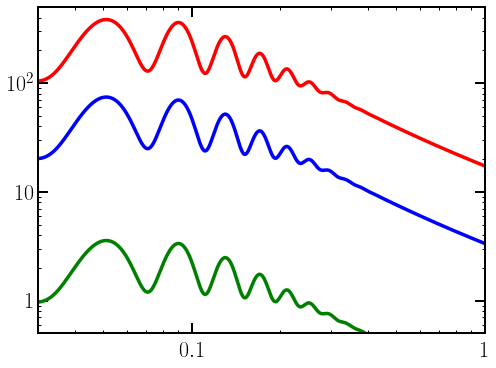

In [29]:
plt.figure(figsize=(8,6))

# plt.loglog(r, ar)

# Attempting to reproduce Julian+
plt.loglog(k, ak_xiv2 * ((0.6 + 0.3 * np.log(0.03/1e-2))*17)**4 * (4.4 * 0.03**(4/3))**2 , color='red')
plt.loglog(k, ak_xiv2 * ((0.6 + 0.3 * np.log(0.02/1e-2))*17)**4 * (4.4 * 0.02**(4/3))**2 , color='blue')
plt.loglog(k, ak_xiv2 * ((0.6 + 0.3 * np.log(0.01/1e-2))*17)**4 * (4.4 * 0.01**(4/3))**2 , color='green')


# plt.loglog(kout, DelTTn / (b2T / 9), color='red')

plt.xlim(3e-2, 1)
plt.ylim(0.5, 500)

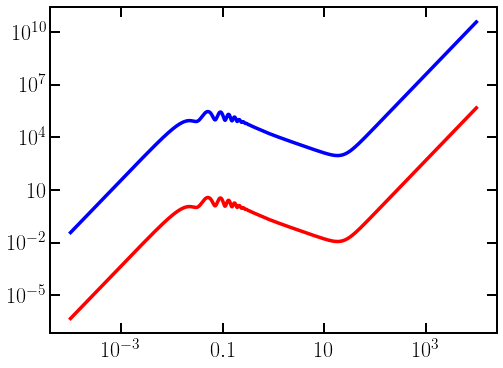

In [63]:
k_fft, Delt_fft = logfft.fftj0(fluc.get_xiv2, -4, 4)

plt.figure(figsize=(8,6))

# plt.loglog(r, ar)

# Attempting to reproduce Julian+
plt.loglog(k, ak_xiv2, color='red')
plt.loglog(k_fft, Delt_fft, color='blue')

Text(0.5, 1.0, '$m_m$ = 100 MeV, $Q = 0.04$')

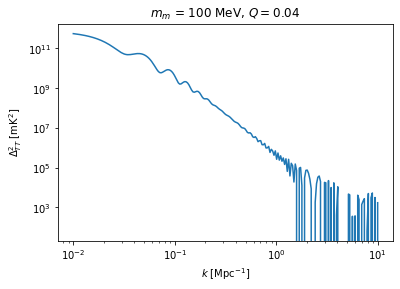

In [ ]:
# plt.loglog(10**klis,DelTTn_old)
plt.loglog(kout,P_T)
# plt.plot(kout, P_T)
# plt.yscale('log')
# plt.loglog(10**klis,b) 

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta_{TT}^2$ [mK$^2$]')

# plt.title(r'$m_m$ = 100 MeV, $Q = 5.4 \times 10^{-4}$')

plt.title(r'$m_m$ = 100 MeV, $Q = 0.04$')

# plt.axis([3e-2, 5, 1e2, 1e7])

Text(0.5, 1.0, '$m_m$ = 100 MeV, $Q = 0.04$')

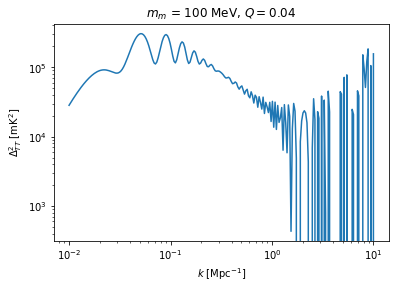

In [ ]:
# plt.loglog(10**klis,DelTTn_old)
plt.loglog(kout,DelTTn)
# plt.plot(kout, DelTTn)
# plt.loglog(10**klis,b) 

plt.xlabel(r'$k$ [Mpc$^{-1}$]')
plt.ylabel(r'$\Delta_{TT}^2$ [mK$^2$]')

# plt.title(r'$m_m$ = 100 MeV, $Q = 5.4 \times 10^{-4}$')

plt.title(r'$m_m$ = 100 MeV, $Q = 0.04$')

# plt.axis([1e-2, 6e-1, 1e2, 1e7])

(100.0, 1000.0)

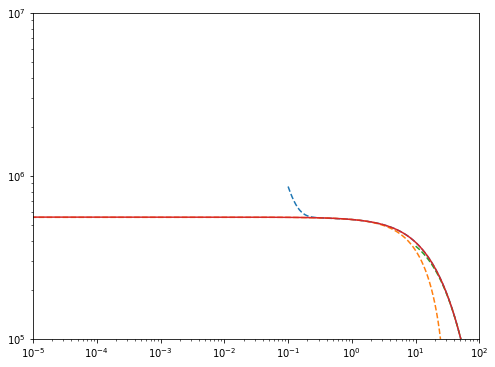

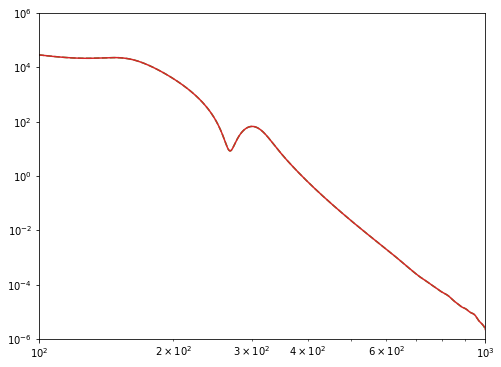

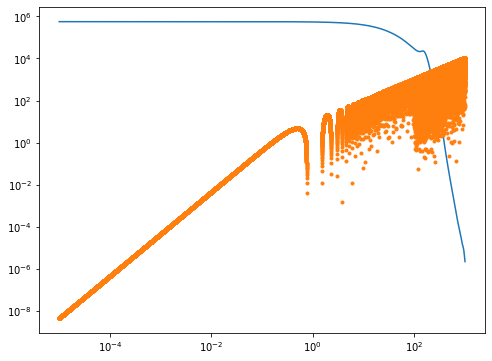

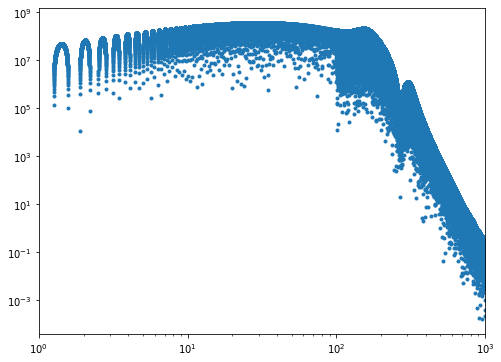

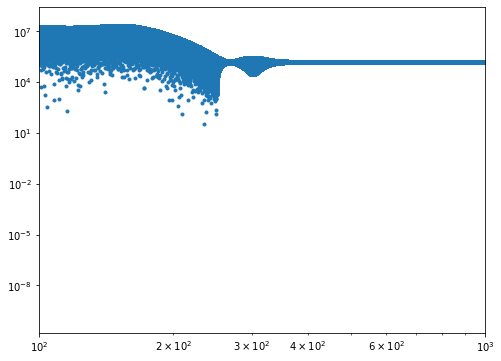

In [ ]:
plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_computed_ary, xiT_computed_ary, '--')
plt.plot(x_small_ary,    xiT_small_ary, '--')
plt.plot(x_large_ary,    xiT_large_ary, '--')
plt.plot(x_full_ary,     xiT_new_ary)
# plt.plot(x_full_ary, 4 * np.pi * x_full_ary ** 2 * spherical_jn(0, kout[200]*x_full_ary), '.')

plt.axis([1e-5, 1e2, 1e5, 1e7])

plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_computed_ary, xiT_computed_ary)
plt.plot(x_small_ary,    xiT_small_ary, '--')
plt.plot(x_large_ary,    xiT_large_ary, '--')
plt.plot(x_full_ary,     xiT_new_ary)
# plt.plot(x_full_ary, 4 * np.pi * x_full_ary ** 2 * spherical_jn(0, kout[200]*x_full_ary), '.')

plt.axis([1e2, 1e3, 1e-6, 1e6])
# plt.axis([2e2, 4e2, 1e0, 1e2])

plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_full_ary,     xiT_new_ary)
plt.plot(x_full_ary, 4 * np.pi * x_full_ary ** 2 * spherical_jn(0, kout[200]*x_full_ary) * kout[200]**3 / (2 * np.pi**2), '.')


ind = -1

plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_full_ary, 4 * np.pi * x_full_ary ** 2 * spherical_jn(0, kout[ind]*x_full_ary) * xiT_new_ary * kout[ind]**3 / (2 * np.pi**2), '.')

plt.xlim(1, 1e3)
# plt.ylim(1e4, 1e7)

plt.figure(figsize=(8,6))

plt.loglog()

plt.plot(x_full_ary[:-1], 4 * np.pi * integrate.cumtrapz(x_full_ary ** 2 * spherical_jn(0, kout[ind]*x_full_ary) * xiT_new_ary, x_full_ary) * kout[ind]**3 / (2 * np.pi**2), '.')

plt.xlim(1e2, 1e3)
# plt.ylim(1e2, 1e7)
